In [1]:
from osmread import parse_file, Way,Node,Relation
import shapely.geometry as shpgeo
%matplotlib inline
import geopandas as gp
from shapely.ops import linemerge
import pandas as pd
import numpy as np
from itertools import chain
from collections import defaultdict
import datetime

# Read OSM

In [2]:
print datetime.datetime.now()
dc_osm = u'washingtonDC 2016-10-25.osm'

ways = []
relations = []
nodes = []
for entity in parse_file(dc_osm):
    if isinstance(entity, Node):
        nodes.append(entity)
    elif isinstance(entity, Way):
        ways.append(entity)
    else:
        relations.append(entity)
    
entities = {}
entities[Node] = nodes
entities[Way] = ways
entities[Relation] = relations
len(nodes), len(ways), len(relations)     
print datetime.datetime.now()

2016-10-27 19:02:01.887000
2016-10-27 19:03:14.398000


In [3]:
def build_idx(entitys):
    return {e.id:i for i, e in enumerate(entitys)}
entity_idx = {}
entity_idx[Node] = build_idx(nodes)
entity_idx[Way] = build_idx(ways)
entity_idx[Relation] = build_idx(relations)

def get_entity(entities, entity_idx, etype, eid):
    idx = entity_idx[etype][eid]
    return entities[etype][idx]


# Functions for converting OSM to shapely

In [4]:

def node2pt(node):
    return shpgeo.Point(node.lon,node.lat)

def lonlat_in_way(way):
    nodes = [get_entity(entities, entity_idx, Node, nid) for nid in way.nodes]
    return [(node.lon, node.lat) for node in nodes]

def way2line(way):
    return shpgeo.LineString(lonlat_in_way(way))

def rltn2cltn(relation):
    cltn = []
    for m in relation.members:
        entity = get_entity(entities, entity_idx, m.type, m.member_id)
        shpobj = way2line(entity) if m.type==Way else node2pt(entity)
        cltn.append(shpobj)
    return shpgeo.GeometryCollection(cltn)

def rltn2poly(relation):
    """
    work for only coninuous lines. if the linestring is not closed, 
    a new line between the first and last node will be added
    """
    cltn = []
    for m in relation.members:
        if m.type==Way:
            way = get_entity(entities, entity_idx, m.type, m.member_id)
            ln = way2line(way)
            cltn.append(ln)
    merged_line = linemerge(cltn)
    return shpgeo.Polygon(merged_line)



test functions

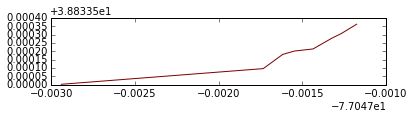

In [5]:
gp.GeoDataFrame([way2line(ways[0])],columns=['geometry']).plot()

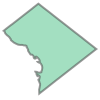

In [6]:
# Border of Washington DC
test_r = get_entity(entities, entity_idx, Relation, 162069)
# gp.GeoDataFrame(rltn2cltn(r),columns=['geometry']).plot()
# print rltn2cltn(test_r)[0].coords[0]
rltn2poly(test_r)

# get OSM data within dc boundary

In [7]:
def get_dc_nodes(dc_boundary):
    print datetime.datetime.now()
    dc_nodes = []
    for node in nodes:
        pt = node2pt(node)
        if pt.intersects(dc_boundary):
            dc_nodes.append(node)
    print datetime.datetime.now()
    return dc_nodes

def get_dc_ways(dc_boundary):
    print datetime.datetime.now()
    dc_ways = []
    way_with_one_node = []
    for way in ways:
        if way.nodes.__len__()>1:
            ln = way2line(way)
            if ln.intersects(dc_boundary):
                dc_ways.append(way)
        else:
            way_with_one_node.append(way)
    print datetime.datetime.now()
    return dc_ways

In [8]:
dc_boundary = rltn2poly(get_entity(entities, entity_idx, Relation, 162069))
dc_lon, dc_lat = dc_boundary.centroid.coords[0]

In [9]:
dc_nodes = get_dc_nodes(dc_boundary)
dc_ways = get_dc_ways(dc_boundary)

2016-10-27 19:03:15.651000
2016-10-27 19:07:39.244000
2016-10-27 19:07:39.245000
2016-10-27 19:08:37.021000


In [10]:
def remove_list_overlap(list_data):
    
    s = [set(li) for li in list_data]
    size = len(s)
    idxes = [i for i in range(size)]
    result = []
    
    for i in xrange(size,-1,-1):
        effect_comb_idx = []
        for idx in combinations(idxes, i+1):
            inter_set = set(s[idx[0]])
            for j in idx:
                inter_set &= s[j]
            if len(inter_set)!=0:
                effect_comb_idx.append([idx,inter_set])
        for idx, inter_set in effect_comb_idx:
            for j in idx:
                s[j]-=inter_set
        result.extend(effect_comb_idx)
    return result

# Target: volumes of different types of places each segments.
1. how to extract places:
    - nodes can be a place, parks could be represented as nodes, cafes, stores etc.
    - ways can be a place. boundaries of a place
    - relation can be a place. Complex combination of nodes and ways; or ways to form a polygon
    - Potential inaccuracy: a node and ways are part of relation, and they have the same tags.
2. find ways and split them into segments
3. find places for segments

## 1. extract places
### Topic:
- Landuse: http://wiki.openstreetmap.org/wiki/Landuse (human activity)(but the difference between Landuse and Landcover may blur in some cases)
    - Landuse tags is "work in progress", so the interpretation of tags may vary in the feature. (ongoing dicussion in wiki)
    - equally named tag: landuse=*
    - detailed tags: military=\*, amenity=\*, leisure=\* and tourism=\*
- Landcover: http://wiki.openstreetmap.org/wiki/Landcover (physical material surface)
    - relavent tags: natural=\*, surface=\*(originally for routable network)
    - equally named tag: landcover=*, this has been proposed.


### places related OSM keys:
- place: http://wiki.openstreetmap.org/wiki/Key:place
    - related tags: wikidata=*; wikipedia=*
    - for nodes, it typically means the recognized centre of the place;
    - for ways, it's a boundary 
- boundary: http://wiki.openstreetmap.org/wiki/Key:boundary
    - Boundaries mark the borders of areas, mostly political, but also of other administrative areas
- landuse: http://wiki.openstreetmap.org/wiki/Key:landuse
    - Mainly used to describe the primary use of land by humans
- amenity: http://wiki.openstreetmap.org/wiki/Key:amenity
    - Covering an assortment of community facilities including parking, restaurant, nightclub and schools.
- building: http://wiki.openstreetmap.org/wiki/Key:building
    - values: residential, industrial, commercial, hospital, etc.
    - mark areas as a building
    - **potential overlap** with building=* and amenity=*: http://www.openstreetmap.org/way/66678735, the boundary of a university is tagged as amenity, and the building inside the area is tagged building
- leisure: http://wiki.openstreetmap.org/wiki/Key:leisure
    - The leisure tag is for places people go in their spare time
- tourism:
    - values: museum, attraction, hotel, zoo, etc.
    - Places and things of specific interest to tourists including places to see, places to stay, things and places providing information and support to tourists
- military=*: http://wiki.openstreetmap.org/wiki/Key:military
- shop: http://wiki.openstreetmap.org/wiki/Key:shop
    - mark the location of a shop and the products that it sells

- man_made: http://wiki.openstreetmap.org/wiki/Key:man_made 
    - A tag for identifying man-made (artificial) structures added to the landscape. See also building=* for buildings.
- natural: http://wiki.openstreetmap.org/wiki/Key:natural 
    - Used to describe a selection of Geological and Landcover features
- surface: http://wiki.openstreetmap.org/wiki/Key:surface
    - see also tags: 
        - material=* http://wiki.openstreetmap.org/wiki/Key:material
    - surface=paved: this is normally an assumption for roads for motor vehicles
    - surface=unpaved: More specific tags can used used for surfaces which are normally classified into paved or unpaved for routing purposes
    - combination tags:
        - smoothness: http://wiki.openstreetmap.org/wiki/Key:smoothness
        - tracktype: http://wiki.openstreetmap.org/wiki/Key:tracktype
        - maxspeed:practical: http://wiki.openstreetmap.org/wiki/Key:maxspeed:practical
     - sidewalk or cycleway related syntax:
         - If a foot- or cycleway was tagged as a tag (not as a separate way) on a highway (i.e., highway=secondary + cycleway=track/lane) sidewalk:surface=paving_stones
         - one side or two sides are different: cycleway:right:surface=asphalt; cycleway:left:surface=paving_stones
- sport: http://wiki.openstreetmap.org/wiki/Key:sport
    - identify one or more sports which can be played within or on some physical feature
    - Since this is a **non-physical tag** it should be combined with one of these (physical) tags: club=sport, leisure=sports_centre, natural=beach, etc.

In [262]:
def get_entities_by_tag(entities, tag, tag_to_exclude=''):
    of_interest = [e for e in entities if tag in e.tags]
    
    print 'tag:', tag,len(of_interest),'/',len(entities)
    print pd.Series([e.tags[tag] for e in of_interest]).value_counts()
    return of_interest

def get_dc_nodes_by_tag(tag, tag_to_exclude=''):
    return get_entities_by_tag(dc_nodes, tag, tag_to_exclude)
def get_dc_ways_by_tag(tag, tag_to_exclude=''):
    return get_entities_by_tag(dc_ways, tag, tag_to_exclude)

In [478]:
tags_of_interest = ['place','landuse', 'amenity', 'building', 'leisure', 'tourism', 
                    'shop', 'man_made', 'natural', 'surface', 'sport',
#                     'military', 'boundary', 
                   ]

tag_to_exclude = 'highway'
osm_ways_of_interest = [get_dc_ways_by_tag(t,tag_to_exclude) for t in tags_of_interest]
osm_nodes_of_interest = [get_dc_nodes_by_tag(t,tag_to_exclude) for t in tags_of_interest]


In [238]:
def get_osm_id(osm_list):
    return [o.id for o in osm_list]

def osm_tags_frequency(osm_data, exclude_tags):
    tag_value_cnt = defaultdict(lambda: defaultdict(int))
    for o in osm_data:
        for k, v in o.tags.items():
            tag_value_cnt[k][v]+=1
    d2l = []
    for k, subd in tag_value_cnt.items():
        if not k in exclude_tags:
            for subk, cnt in subd.items():
                d2l.append([k,subk,cnt])
    tag_cnt_df = pd.DataFrame(d2l,columns=['tag','value','cnt']).groupby('tag').agg(sum).sort('cnt',ascending=False)
    return tag_value_cnt, tag_cnt_df
    
def osm2gpdf(osm_data, osm_type, feature_tags, color_code):
    o2shp_func = node2pt if osm_type=='Node' else way2line
    osm_list = []
    columns = ['id']+feature_tags+['geometry']
    for o in osm_data:
        tags = o.tags
        features = [o.id]
        for t in feature_tags:
            features.append(tags.get(t, ''))
        features.append(o2shp_func(o))
        osm_list.append(features)

    gpdf = gp.GeoDataFrame(osm_list,columns=columns)
    gpdf['color'] = color_code
    return gpdf

In [270]:
colors_of_interest = ['#000000', '#312184', '#AE281C', '#F03129', '#D69C4A', '#FF6B01', '#6A4A33', '#CE3122', '#AD291A', '#593A5A', '#292931', '#3A3184', '#9B5229', '#F0CE15']
osm_ways_of_interest_gpdfs = [osm2gpdf(ow, 'Way',tags_of_interest,colors_of_interest[i]) for i,ow in enumerate(osm_ways_of_interest)]
osm_nodes_of_interest_gpdfs = [osm2gpdf(on, 'Node',tags_of_interest ,colors_of_interest[i]) for i,on in enumerate(osm_nodes_of_interest)]

In [240]:
osm_nodes_of_interest_gpdfs[0]

,id,place,landuse,amenity,building,leisure,tourism,shop,man_made,natural,surface,sport,geometry,color
0,49792620,locality,,,,,,,,,,,POINT (-76.9602502 38.88628),#000000
1,157560663,neighbourhood,,,,,,,,,,,POINT (-77.0113652 38.9167782),#000000
2,157562916,neighbourhood,,,,,,,,,,,POINT (-76.9749029 38.8980036),#000000
3,157590304,neighbourhood,,,,,,,,,,,POINT (-77.0580329 38.9509441),#000000
4,157591605,neighbourhood,,,,,,,,,,,POINT (-77.0880336 38.9312222),#000000
5,157596835,neighbourhood,,,,,,,,,,,POINT (-77.03997699999999 38.9265002),#000000
6,157599737,neighbourhood,,,,,,,,,,,POINT (-76.92886280000001 38.8945564),#000000
7,157610884,suburb,,,,,,,,,,,POINT (-77.0294287 38.9256724),#000000
8,157610971,neighbourhood,,,,,,,,,,,POINT (-76.9869338 38.9120667),#000000
9,157618698,neighbourhood,,,,,,,,,,,POINT (-76.96868019999999 38.8566529),#000000


In [480]:
for i,x in enumerate(osm_ways_of_interest_gpdfs):
    print tags_of_interest[i], x.shape[0], osm_nodes_of_interest_gpdfs[i].shape[0]

place 9 117
landuse 659 19
amenity 6705 4863
building 160705 570
leisure 1540 317
tourism 135 551
shop 165 1324
man_made 172 92
natural 1537 2293
surface 62 1
sport 416 27


In [271]:
osm_nodes_merge_gpdf = osm_nodes_of_interest_gpdfs[0][['id','geometry']]
for i in range(1, len(osm_nodes_of_interest_gpdfs)):
    osm_nodes_merge_gpdf = osm_nodes_merge_gpdf.append(osm_nodes_of_interest_gpdfs[i][['id','geometry']],ignore_index=True)
print osm_nodes_merge_gpdf.shape
osm_nodes_merge_gpdf.drop_duplicates('id',inplace=True)
print osm_nodes_merge_gpdf.shape

osm_ways_merge_gpdf = osm_ways_of_interest_gpdfs[0][['id', 'geometry']]
for i in range(1, len(osm_ways_of_interest)):
    osm_ways_merge_gpdf = osm_ways_merge_gpdf.append(osm_ways_of_interest_gpdfs[i][['id','geometry']],ignore_index=True)
print osm_ways_merge_gpdf.shape
osm_ways_merge_gpdf.drop_duplicates('id',inplace=True)
print osm_ways_merge_gpdf.shape

(10174, 2)
(10102, 2)
(172105, 2)
(170560, 2)


In [161]:
tag = 'amenity'
amenity_ways = get_dc_ways_by_tag(tag)
amenity_nodes = get_dc_nodes_by_tag(tag)
feature_tags = ['access', 'building', 'religion','denomination','diplomatic','parking','wheelchair', 
                    'building:levels', 'park_ride']
amenity_ways_gpdf = osm2gpdf(amenity_ways, 'Way', feature_tags, '#000')
amenity_ways_gpdf

,id,access,building,religion,denomination,diplomatic,parking,wheelchair,building:levels,park_ride,geometry,color
0,4721372,,,,,,,,,,"LINESTRING (-76.99258089999999 38.8794105, -76...",#000
1,26295917,,,,,,,,,,"LINESTRING (-77.0676373 38.897661, -77.0674961...",#000
2,26296023,,,,,,,,,,"LINESTRING (-77.0379118 38.8787938, -77.037649...",#000
3,33859507,,,,,,,,,,"LINESTRING (-77.0927128 38.9376079, -77.092300...",#000
4,38075679,,,,,,multi-storey,,,,"LINESTRING (-77.0897974 38.9369564, -77.089469...",#000
5,38094614,,,,,,,,,,"LINESTRING (-77.08931560000001 38.9384425, -77...",#000
6,38607097,,,,,,,,,,"LINESTRING (-77.0899704 38.9385463, -77.089790...",#000
7,40756639,,,,,,surface,,,,"LINESTRING (-77.0442456 38.9277047, -77.044216...",#000
8,41976765,,,,,,surface,,,,"LINESTRING (-77.0472212 38.9274437, -77.047213...",#000
9,42363194,,office,,,,,,,,"LINESTRING (-77.0049315 38.8910327, -77.003889...",#000


In [148]:
tag_value_cnt, tag_cnt_df = osm_tags_frequency(amenity_ways, 'amenity')
print tag_value_cnt['fee']
print tag_value_cnt['park_ride']
print tag_value_cnt['area']
tag_cnt_df[tag_cnt_df.cnt>1][40:]


defaultdict(<type 'int'>, {u'yes': 13, u'AU permit required': 1, u'no': 8})
defaultdict(<type 'int'>, {u'yes': 4, u'no': 11})
defaultdict(<type 'int'>, {u'yes': 14})


,cnt
tag,
building:levels,36
opening_hours,36
gnis:edited,34
gnis:reviewed,33
wikipedia,23
fee,22
park_ride,15
area,14
capacity,14


## 2. find ways and split
### ways related OSM keys:
- general:
    - highway: http://wiki.openstreetmap.org/wiki/Key:highway
    - oneway: http://wiki.openstreetmap.org/wiki/Key:oneway?uselang=en
    - lanes: http://wiki.openstreetmap.org/wiki/Key:lanes (there is tag for lanes in different directions but not included in the output rightnow(2016-10-22 14:46:09)
- walking:
    - sidewalk: http://wiki.openstreetmap.org/wiki/Key:sidewalk?uselang=en
    - footway: http://wiki.openstreetmap.org/wiki/Key:footway
    - crossing: http://wiki.openstreetmap.org/wiki/Key:crossing
    - foot: http://wiki.openstreetmap.org/wiki/Key:foot?uselang=en
        - Legal access restriction for pedestrians.
- bicycle (http://wiki.openstreetmap.org/wiki/Bicycle):
    - cycleway: http://wiki.openstreetmap.org/wiki/Cycleway; cycleway have two instance: cycleway=* and highway=cycleway
    - bicycle_road: http://wiki.openstreetmap.org/wiki/Key:bicycle_road
    - bicycle: http://wiki.openstreetmap.org/wiki/Key:bicycle
    
### highway value related to walking or bycycling:
- general:
    - in nodes:
        - highway=stop: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dstop
        - highway=trafic_signals: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dtraffic_signals
    - in ways:
        - highway=residential: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dresidential
        - highway=servcie: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dservice(Note that it is NOT services)
        - highway=track: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dtrack(similar to highway=path except its width is enough for two-track vehicle)
- walking or bicycling:
    - highway=path: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dpath
- walking:
    - highway=pedestrian: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dpedestrian
    - highway=footway: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dfootway
    - highway=steps: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dsteps
- bicycling:
    - highway=cycleway: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dcycleway
    - highway=crossing: http://wiki.openstreetmap.org/wiki/Tag:highway%3Dcrossing
    

### questions for 2.


1. solved:
    1. how to direction of street? A: direction follows node directions; unless oneway=-1 which means opposite direction. see here:https://help.openstreetmap.org/questions/15450/detection-of-direction-of-one-way-streets
    2. seperate roads and other path for cyclist and pedestrians
        1. footway,sidewalk should not put together into segments. these should serve as features for segments(they could be parallel with roads or intersect with roads as shown below) <img src='non-motor path3.png' style="max-width:100%; width: 30%">
        2. crossing: some crossing intersect with roads(e.g. 367152826, 396767776) some don't(e.g. 396767844, 396767836) [LATER]
    3. nodes have key=highway too, such as highway=trafic_signals
        <img src='crossing as node not way.png' style="max-width:100%; width: 30%">
        
- TODO:
    2. merge segments that are not at intersection(e.g. way id =397277578) [lATER]
    3. figure whether a way of pedestrian/cyclist can be a feature for a segment
    
- Need **confirmation**:
    1. by excluding non-motor vehicle highways like footway(1.A.a), some path wouldn't show on the base map, will these roads be evaluted for safety?
        - e.g. https://www.openstreetmap.org/way/44814991#map=18/38.92166/-77.06834&layers=D
        <img src='non-motor path.png' ><img src='non-motor path2.png'  style="max-width:100%; width: 30%">
         

In [18]:
tag = 'highway'
hway_nodes = get_entities_by_tag(dc_nodes, tag)

tag: highway 4703 / 1652906
crossing                  2359
traffic_signals           1454
stop                       404
bus_stop                   309
motorway_junction           82
turning_circle              74
turning_loop                12
speed_camera                 3
elevator                     2
emergency_access_point       1
mini_roundabout              1
give_way                     1
milestone                    1
dtype: int64


In [109]:
d['route']

defaultdict(<type 'int'>, {u'Union Station - Navy Yard Metro': 18, u'Old Town Trolley DC Duck;Old Town Trolley National Mall and Downtown Loop': 2, u'Convention Center - SW Waterfront': 28, u'Old Town Trolley DC Duck;Old Town Trolley National Mall and Downtown Loop;Smithsonian - National Gallery of Art': 1, u'Tourmobile Mall Route': 9, u'Georgetown Connector Route 2 - M Street Line': 9, u'Georgetown University GUTS Bus Law Center': 1, u'Kennedy Center Shuttle': 3, u'Old Town Trolley National Cathedral, Uptown & Georgetown Loop': 4, u'Old Town Trolley National Cathedral, Uptown & Georgetown Loop;Old Town Trolley National Mall and Downtown Loop': 1, u'Open Top Sightseeing': 1, u'Woodley Park - Adams Morgan - McPherson Square Metro': 16, u'Smithsonian - National Gallery of Art': 11, u'S1, S2, S4, S9': 2, u'Georgetown University GUTS Bus Wisconsin Avenue Shuttle': 2, u'Georgetown University GUTS Bus Dupont Circle': 1, u'Georgetown University GUTS Bus Arlington Loop;Georgetown University GU

In [19]:
d = defaultdict(lambda: defaultdict(int))
for n in hway_nodes:
    for k, v in n.tags.items():
        d[k][v]+=1
d2l = []
for k, subd in d.items():
    if k!='highway':
        for subk, cnt in subd.items():
            d2l.append([k,subk,cnt])
pd.DataFrame(d2l,columns=['tag','value','cnt']).groupby('tag').agg(sum).sort('cnt',ascending=False)

,cnt
tag,
crossing,999
source,729
wheelchair,539
traffic_signals,178
route,169
dcgis:gis_id,166
dcgis:pubdate,166
dcgis:dataset,166
location,166


In [20]:
hway_nodes_list = []
tags_of_interest = ['highway', 'crossing', 'wheelchair', 'traffic_signals', 'shelter', 'stop', 'bicycle', 'bench']
columns = ['id']+tags_of_interest+['geometry']
for n in hway_nodes:
    tags = n.tags
    features = [n.id]
    for t in tags_of_interest:
        features.append(tags.get(t, ''))
    features.append(node2pt(n))
    hway_nodes_list.append(features)

hway_nodes_gpdf = gp.GeoDataFrame(hway_nodes_list,columns=columns)
hway_nodes_gpdf['geometry'] = hway_nodes_gpdf.buffer(0.00001)
hway_nodes_gpdf['color'] = '#00F'

In [468]:
highways = [way for way in dc_ways if 'highway' in way.tags]
print '%10s' % 'highways', len(highways)
val_for_ped_cyc = ['path','pedestrian','footway','steps','cycleway','crossing']
ways_for_ped_cyc = defaultdict(list)
ways_motors = []
for hw in highways:
    highway_val = hw.tags['highway']
    if highway_val in val_for_ped_cyc:
        ways_for_ped_cyc[highway_val].append(hw)
    else:
        ways_motors.append(hw)

for val in ways_for_ped_cyc:
    print '%10s' % val, len(ways_for_ped_cyc[val])

print '%10s' % 'motors',len(ways_motors)

  highways 18506
      path 186
  cycleway 229
     steps 157
   footway 4401
pedestrian 76
    motors 13457


In [469]:
def split_way_df(way_df):
    sublist=[]
    sublists = []
    for _, nodeid, shared in way_df[['nodeid','shared']].itertuples():
        if shared and sublist:
            sublist.append(nodeid)
            sublists.append(sublist)
            sublist = [nodeid]
        else:
            sublist.append(nodeid)
    if not shared:
        sublists.append(sublist)
    return sublists

def get_flatten_segments(segments, ways):
    columns = ['STREETSEGID','highway','layer', 'oneway','lanes','traffic_signals',
               'sidewalk', 'footway', 'crossing', 'bicycle_road','bicycle', 'nodes']
    flatten_segments = []
    for idx, segments in segments.iteritems():
        wayid, highway_value = ways[idx].id, ways[idx].tags['highway']
        layer = ways[idx].tags.get('layer',0)
        oneway = ways[idx].tags.get('oneway','')
        lanes = ways[idx].tags.get('lanes','')
        traffic_signals = ways[idx].tags.get('traffic_signals','')
        sidewalk = ways[idx].tags.get('sidewalk','')
        footway = ways[idx].tags.get('footway','')
        crossing = ways[idx].tags.get('crossing','')
        bicycle_road = ways[idx].tags.get('bicycle_road','')
        bicycle = ways[idx].tags.get('bicycle','')
        flatten_segments.extend([('%s_%d' % (wayid,i), highway_value,layer, oneway, lanes, traffic_signals,
                                  sidewalk,footway,crossing, bicycle_road,bicycle,seg) 
                                 for i, seg in enumerate(segments)])
    flatten_segments = pd.DataFrame(flatten_segments,columns=columns)
    return flatten_segments


def ways2segments(ways):
    print 'len input ways', len(ways)
    # 1. find shared nodes(interssection nodes)
    all_nodes = [way.nodes for way in ways]
    flatten_nodes = pd.Series(list(chain.from_iterable(all_nodes)))
    nodes_frequency = flatten_nodes.value_counts()
    shared_nodes = set(nodes_frequency[nodes_frequency>1].index.tolist())
    print 'len shared nodes', len(shared_nodes)
    
    # 2. tag ways with shared nodes
    way_idxes = list(chain.from_iterable([[i]*len(way.nodes) for i, way in enumerate(ways)]))
    df = pd.DataFrame(zip(way_idxes, flatten_nodes),columns=['wayidx','nodeid'])
    df['shared'] = df.nodeid.isin(shared_nodes)
    wayidx_with_shared_nodes = set(df[df.shared].wayidx.values)
    print 'len of ways with shared nodes', len(wayidx_with_shared_nodes)
    
    # 3. get segments
    segments = df.groupby('wayidx').apply(split_way_df)
    flatten_segments = get_flatten_segments(segments,ways)
    
    idx_sharednode_for_ways = df[df.shared].groupby('nodeid').wayidx.apply(list).to_dict()
    
    
    return flatten_segments
    
    
# test_segs,idx_sharednode_for_ways = ways2segments(highways[:100])
flatten_segments_df = ways2segments(ways_motors)

len input ways 13457
len shared nodes 19396
len of ways with shared nodes 13438


In [23]:
flatten_segments_df['geometry'] = flatten_segments_df.apply(way2line, axis=1)
colors = ['#F6B332','#D7410E','#111E90','#338800','#DAD2D8']
# flatten_segments_df['color'] = flatten_segments_df.STREETSEGID.apply(lambda x: colors[int(x.split('_')[1]) % len(colors)])
flatten_segments_df['color'] = '#F6B332'

In [24]:
print flatten_segments_df.shape, flatten_segments_df.columns
for i in flatten_segments_df.columns[1:-3]:
    print i
    print flatten_segments_df[i].value_counts()
    print

(31635, 14) Index([u'STREETSEGID', u'highway', u'layer', u'oneway', u'lanes',
       u'traffic_signals', u'sidewalk', u'footway', u'crossing',
       u'bicycle_road', u'bicycle', u'nodes', u'geometry', u'color'],
      dtype='object')
highway
residential       13002
service            7917
tertiary           3223
primary            3086
secondary          2392
motorway            506
motorway_link       399
unclassified        340
trunk               277
primary_link        139
track               110
trunk_link           91
secondary_link       72
tertiary_link        56
construction         10
services              9
yes                   5
living_street         1
dtype: int64

layer
0     31105
1       367
-1      106
2        50
3         3
-2        2
5         1
-5        1
dtype: int64

oneway
              24080
yes            7113
no              419
reversible       22
-1                1
dtype: int64

lanes
       20236
2       5432
4       1953
1       1791
3       1607
6  

## 3. Find places for segments
bfr = 8m is far from enough <img src="place for seg bfr=8.png" style="width:30%">
as bfr increase, the corner places increase <img src="corner places.png" style="width:30%">

In [199]:
flatten_segments_df_simplified = gp.GeoDataFrame(flatten_segments_df[['STREETSEGID','geometry']].copy())

In [272]:
osm_nodes_merge_gpdf['type'] = 'Node'
osm_ways_merge_gpdf['type'] = 'Way'

osm_places = osm_nodes_merge_gpdf.append(osm_ways_merge_gpdf,ignore_index=True)

In [273]:
type(osm_places), osm_places.shape, type(flatten_segments_df_simplified),flatten_segments_df_simplified.shape

(geopandas.geodataframe.GeoDataFrame,
 (180662, 3),
 geopandas.geodataframe.GeoDataFrame,
 (31635, 2))

In [274]:
osm_places.crs = {'init': 'epsg:4326'}
# flatten_segments_df_simplified.crs = {'init': 'epsg:4326'}
osm_places.crs, flatten_segments_df_simplified.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [246]:
def check_crs(gpdf, epsg_code):
    if not gpdf.crs:
        raise ValueError('GeoDataFrame does not have crs')
    if not gpdf.crs['init'] == u'epsg:%s' % epsg_code:
        print gpdf.crs, 'convert to epsg:%s' %epsg_code
        return gpdf.to_crs(epsg=epsg_code)
    return gpdf


In [275]:
osm_places_crs = check_crs(osm_places, 3559)
# flatten_segments_df_simplified_crs = check_crs(flatten_segments_df_simplified, 3559)

{'init': 'epsg:4326'} convert to epsg:3559


In [328]:
def get_places_id_for_seg(segments, osm_places, bfr=20):
    segments, osm_places = check_crs(segments, 3559), check_crs(osm_places, 3559)
    osm_places.geometry = osm_places.geometry.apply(lambda x: x.buffer(1) if x.type=='Point' else x)
    segments_bfr = segments.copy()
    segments_bfr.geometry = segments_bfr.buffer(bfr*1.1)
    jn_seg_places = gp.tools.sjoin(segments_bfr, osm_places, how='left')
    return jn_seg_places

jn_seg_places = get_places_id_for_seg(flatten_segments_df_simplified_crs, osm_places_crs)

In [332]:
jn_seg_places.drop(['geometry','index_right'], inplace=True, axis=1)
print jn_seg_places.shape
jn_seg_places_merge = jn_seg_places.merge(flatten_segments_df[['STREETSEGID', 'geometry']],how='left').merge(osm_places,left_on=['id','type'], right_on=['id','type'],how='left')

(362446, 3)


In [481]:
dc_ways[:10]

[Way(id=4681186L, version=4, changeset=28269235, timestamp=1421734870, uid=24440, tags={u'highway': u'residential'}, nodes=(1391829849L, 281072L, 3299878446L, 3299878455L, 2921446557L, 281074L)),
 Way(id=4721369L, version=4, changeset=21358023, timestamp=1395985048, uid=2005474, tags={u'leisure': u'park'}, nodes=(2748976062L, 30066940L, 30066941L, 30066942L, 2748976062L)),
 Way(id=4721372L, version=1, changeset=86075, timestamp=1181270523, uid=867, tags={u'amenity': u'school', u'created_by': u'JOSM'}, nodes=(30066955L, 30066952L, 30066953L, 30066954L, 30066955L)),
 Way(id=4725152L, version=4, changeset=9413560, timestamp=1317151506, uid=207745, tags={u'source:HFCS': u'District of Columbia (DC GIS)', u'lanes': u'1', u'name': u'Texas Avenue Southeast', u'oneway': u'yes', u'HFCS': u'Collector', u'highway': u'secondary'}, nodes=(649840226L, 649840253L, 649840259L, 649840263L, 649840266L, 649840270L)),
 Way(id=4725153L, version=6, changeset=32041113, timestamp=1434590610, uid=85673, tags={u

In [345]:
# calculate tags of places
tags_only = set(['accees','denomination','diplomatic','man_made','religion','shop','sport','tourism'])
tags_with_value = {
    'amenity':
        set(['atm','bank','bar','bench','bicycle_parking','bicycle_rental',
        'cafe','parking','school','restaurant','place_of_worship','university',
        'post_box','fast_food','embassy','fuel','waste_basket','drinking_water',
        'knidergarten','hospital','pharmacy','library','post_office','theatre',
        'recycling','polic','college','fire_station','parking_entrance','arts_centre',
        'nightclub','social_facility','clinic','dentist','hospital (historic)']),
    'bicycle':set(['no']),
    'building': set(['yes','apartments', 'university', 'commercial', 'residential', 
                     'terrace', 'retail', 'house', 'church', 'roof', 'school', 'office', 
                     'garage', 'construction', 'civic', 'hospital', 'public', 'burial_vault', 
                     'no', 'Commercial', 'dormitory', 'hotel', 'industrial', 'parking', 
                     'Apartments', 'hut', 'warehouse', ]),
    'building:levels': set(['2', '1', '1.5', '2.5', '3',]),
    'landuse': set(['residential', 'grass', 'retail', 'commercial', 'military', 'cemetery', 'construction', 'recreation_ground', 'industrial']), 
    'leisure': set(['park', 'pitch', 'garden', 'sports_centre', 'playground', 'golf_course', 'stadium', 'marina']),
    'natural': set(['wood', 'tree', 'water', 'sand', 'grass', 'wetland']),
    'park_ride': set(['no','yes']),
    'parking': set(['lane','surface']),
    'place': set(['neighbourhood']),
    'surface': set(['asphalt', 'grass', 'paved', 'concrete']),
    'wheelchair': set(['yes','no','limited']),
}

segs_places_count = {}
for segid, group in jn_seg_places_merge.groupby('STREETSEGID'):
    places_count = defaultdict(int)
    if group['id'].isnull().all():
#         print segid, 'id is null, groupshape:', group.shape[0]
        continue
    for eid, etype in group[['id','type']].values:
        entity_type = {'Way':Way, 'Node':Node}[etype]
        place = get_entity(entities,entity_idx,entity_type,eid)
        for k,v in place.tags.items():
            if k in tags_with_value:
                if v in tags_with_value[k]:
                    places_count[(k,v)]+=1
                else:
                    places_count[(k,'agg_tags')]+=1
            elif k in tags_only:
                places_count[(k,'agg_tags')]+=1

    segs_places_count[segid] = places_count
df = pd.DataFrame.from_dict(segs_places_count)

In [346]:
df_stack = df.stack()
df_stack = df_stack.reset_index()
df_stack.columns = ['tag','value','STREETSEGID','CNT']
df_stack.groupby(['tag','value']).agg(sum).shape
df_stack.to_csv('seg_places_cnt.csv')
df_stack.groupby(['tag','value']).agg(sum).to_csv('seg_places_cnt_sum.csv')

In [386]:
df_stack.STREETSEGID.value_counts().shape

(30244L,)

In [387]:
df_stack.shape, flatten_segments_df_simplified.shape

((85340, 5), (31635, 2))

In [379]:
df_stack.CNT.max()

133.0

4.89783979995


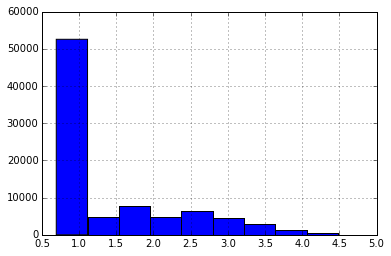

In [390]:
def gradient_color(percent):
    min_color = np.array([251,248,179])
    max_color = np.array([248,105,107])
    return '#%02x%02x%02x' % tuple([int(k) for k in min_color+(max_color-min_color)*percent])

def get_color(df):
    df['color'] = df.CNT+1
    df['color'] = np.log(df['color'])
    print df['color'].max()
    df['color'].hist()
    df['color'] = df['color']/df['color'].max()
    df['color'] = df['color'].apply(gradient_color)

get_color(df_stack)

In [376]:
df_stack.head()

,tag,value,STREETSEGID,CNT,color
0,amenity,agg_tags,104456365_0,1,#78b178
1,amenity,agg_tags,108402596_0,1,#78b178
2,amenity,agg_tags,109582176_1,1,#78b178
3,amenity,agg_tags,109663677_0,1,#78b178
4,amenity,agg_tags,112271634_1,2,#84aa77


In [277]:

# remove overlap or blocked places 
# LATER

for segid, group in jn_seg_places_merge.groupby('STREETSEGID'):
    print segid
    if group['id'].isnull().all():
        continue
    distance = group.apply(lambda x: x.geometry_x.distance(x.geometry_y), axis=1).values
    # see whether is intersected
    if distance.min()==0:
        intersected_poly = group.iloc[distance.argmin()]
        intersection = intersected_poly.geometry_x.intersection(intersected_poly.geometry_y)
        # if part of the seg is within the intersected poly
        if intersection.type!='Point':
            print 'not point'
        break

(6987, 3)


# Visualization of data



5.5872486584


,STREETSEGID,CNT,tag_value,geometry,color
0,102416739_0,5,<br>natural=wood: 3<br>leisure=park: 2,"LINESTRING (-76.9530027 38.8662968, -76.953124...",#faca9b
1,102416743_0,5,<br>leisure=park: 2<br>amenity=parking: 1<br>l...,"LINESTRING (-76.96977320000001 38.8663168, -76...",#faca9b
2,102416743_1,5,<br>leisure=park: 2<br>amenity=parking: 1<br>l...,"LINESTRING (-76.9700588 38.8663247, -76.970097...",#faca9b
3,102416743_2,5,<br>leisure=park: 2<br>amenity=parking: 1<br>l...,"LINESTRING (-76.97009749999999 38.8663704, -76...",#faca9b
4,102416743_3,5,<br>leisure=park: 2<br>amenity=parking: 1<br>l...,"LINESTRING (-76.9700588 38.8663247, -76.970108...",#faca9b
5,102416746_0,5,<br>leisure=park: 5,"LINESTRING (-76.9737167 38.8633802, -76.973737...",#faca9b
6,102416748_0,5,<br>natural=wood: 4<br>leisure=park: 1,"LINESTRING (-76.9486582 38.872067, -76.9486603...",#faca9b
7,102416755_0,3,<br>leisure=park: 2<br>natural=wood: 1,"LINESTRING (-76.9678407 38.8663722, -76.967783...",#fad4a1
8,102416755_1,3,<br>leisure=park: 2<br>natural=wood: 1,"LINESTRING (-76.9677832 38.8663706, -76.967840...",#fad4a1
9,102416755_2,3,<br>leisure=park: 2<br>natural=wood: 1,"LINESTRING (-76.9678407 38.8663722, -76.967909...",#fad4a1


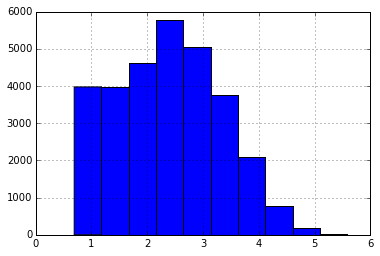

In [461]:
all_cnt = []
iii=0
for seg, group in df_stack.groupby('STREETSEGID'):
    tag_value_cnt = group.groupby(['tag','value']).agg(sum).reset_index()
    tag_value_cnt = tag_value_cnt.sort('CNT', ascending=False).values
    tag_value_cnt = ['%s=%s: %.0f' % (tag, value, cnt) for tag, value, cnt in tag_value_cnt]
    tag_value_cnt = '<br>'+'<br>'.join(tag_value_cnt)
    all_cnt.append([seg, group.CNT.sum(), tag_value_cnt])
    
    
all_cnt_df = pd.DataFrame(all_cnt, columns=['STREETSEGID','CNT','tag_value'])
all_cnt_df = all_cnt_df.merge(flatten_segments_df_simplified)
get_color(all_cnt_df)
# all_cnt_df

In [463]:
# visualizing counts of places
html_title = 'Visulization of places cnt for OSM segments'
file_name = 'osmsegs_place_cnt'
lon, lat  = dc_lon, dc_lat
zoom = 11
init_layers = ['light']
map_layers = ['light','streets','satellite']
binding_data, gpdfs = [],[]
binding_data.append(['agg_all_tags', 'cnts of all kinds of places'])
gpdfs.append(gp.GeoDataFrame(all_cnt_df))

for name, group in df_stack.merge(flatten_segments_df_simplified).groupby(['tag','value']):
    display_text = '%s_%s' % name
    binding_data.append([display_text.replace(':','_').replace('(','_').replace(')','_')\
                         .replace(' ','').replace('.','_'),display_text])
    gpdfs.append(gp.GeoDataFrame(group))

create_map_visualization(html_title, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)


In [130]:
# plotting joined seg and places - preparing data
way_ids =set(jn_seg_places[jn_seg_places['type']=='Way'].id.values)
node_ids =set(jn_seg_places[jn_seg_places['type']=='Node'].id.values)
len(way_ids), len(node_ids)
nodes_gpdf = gp.GeoDataFrame(jn_seg_places[jn_seg_places['type']=='Node'][['STREETSEGID','id']].groupby('id').STREETSEGID.apply(list))
nodes_gpdf= nodes_gpdf.reset_index().merge(osm_nodes_merge_gpdf)
nodes_gpdf['color'] = '#111E90'
nodes_gpdf.geometry = nodes_gpdf.buffer(0.00001)
# nodes_gpdf
ways_gpdf = gp.GeoDataFrame(jn_seg_places[jn_seg_places['type']=='Way'][['STREETSEGID','id']].groupby('id').STREETSEGID.apply(list))
ways_gpdf= ways_gpdf.reset_index().merge(osm_ways_merge_gpdf)
ways_gpdf['color'] = '#D7410E'
# ways_gpdf

flatten_segments_df_simplified_crs_bfr = flatten_segments_df_simplified_crs[10:2000].copy()
flatten_segments_df_simplified_crs_bfr.geometry = flatten_segments_df_simplified_crs_bfr.buffer(20)
flatten_segments_df_simplified_crs_bfr = flatten_segments_df_simplified_crs_bfr.to_crs(epsg=4326)
flatten_segments_df_simplified_crs_bfr['color'] = '#338800'

In [135]:
# plotting joined seg and places
from leaflet_creation_v2 import create_map_visualization
html_title = 'OpenStreetMap segments and places'
file_name = 'osmsegs_places'
lon, lat  = dc_lon, dc_lat
zoom = 13
init_layers = ['streets', 'osmsegs']
map_layers = ['light','streets','satellite']
binding_data=[
    ['osmsegs','OpenStreetMap segments'],
]
gpdfs = [
#     gp.GeoDataFrame(flatten_segments_df).drop('nodes',axis=1)
    flatten_segments_df_simplified_crs_bfr
]
gpdfs.append(nodes_gpdf)
binding_data.append(['nodes_gpdf','nodes'])

gpdfs.append(ways_gpdf)
binding_data.append(['ways_gpdf','ways_gpdf'])


create_map_visualization(html_title, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)


In [192]:
# plotting everything
from leaflet_creation_v2 import create_map_visualization
html_title = 'OpenStreetMap segments'
file_name = 'osmsegs'
lon, lat  = dc_lon, dc_lat
zoom = 13
init_layers = ['streets', 'osmsegs']
map_layers = ['light','streets','satellite']
binding_data=[
#     ['osmsegs','OpenStreetMap segments'],
]
gpdfs = [
#     gp.GeoDataFrame(flatten_segments_df).drop('nodes',axis=1)
]
colors_ = ['#D7410E','#111E90','#338800','#F00','#0F0']
for i, (key,value) in enumerate(ways_for_ped_cyc.items()):
    if len(value):
        df_ = pd.DataFrame(value, columns=Way._fields)
        df_['geometry'] = df_.apply(way2line, axis=1)
        df_['color'] = colors_[i%len(colors_)]
        df_['highway'] = key
        gpdfs.append(gp.GeoDataFrame(df_[['color','geometry','highway']]))
        binding_data.append([key,'highway=%s'%key])

# gpdfs.append(hway_nodes_gpdf)
# binding_data.append(['hway_nodes','nodes with highway=*'])

for i, tag in enumerate(tags_of_interest):
    copy_osm_node = osm_nodes_of_interest_gpdfs[i].copy()
    copy_osm_node.geometry = copy_osm_node.buffer(0.00001)
    gpdfs.append(copy_osm_node)
    binding_data.append(['nodes_%s' % tag, 'nodes with %s=*' % tag])
    gpdfs.append(osm_ways_of_interest_gpdfs[i])
    binding_data.append(['ways_%s' % tag, 'ways with %s=*' % tag])
    

create_map_visualization(html_title, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)
